In [1]:
import numpy as np
from lpne.models import DcsfaNmf
import matplotlib.pyplot as plt
from scipy.spatial import distance as dis
from scipy.special import softmax
import pickle
import matplotlib.image as image
from scipy.optimize import linear_sum_assignment as hung_match

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
def get_mean_cos_dis(networks):
    
    n_nets = len(networks)
    cos_dis_mat = np.ones((n_nets,n_nets))
    
    for i in range(n_nets):
        for j in range(n_nets):
            cos_dis_mat[i,j] = dis.cosine(networks[i],networks[j])
            
    off_diag = 1 - np.eye(n_nets,n_nets)
    
    mean_cos_dis = np.mean(cos_dis_mat[off_diag==1])
    
    return mean_cos_dis
    
    
    
def match_similar_networks(networks):
    n_nets,n_folds,_ = networks.shape
    
    match_networks = np.zeros_like(networks)
    match_network_map = {}
    match_cos_dis_list = []
    for fold in range(n_folds):
        
        for net in range(n_nets):
            reference_net = networks[net,fold,:]
            
            best_cos_dis = 1.0
            best_match_net = np.zeros_like(reference_net)
            best_match_idx = [0,0]
            for other_fold in range(n_folds):
                for other_net in range(n_nets):
                    
                    if other_fold != fold:
                        comp_net = networks[other_net,other_fold,:]
                        cos_dis = dis.cosine(reference_net,comp_net)
                        
                        if cos_dis < best_cos_dis:
                            best_cos_dis = cos_dis
                            best_match_net = comp_net
                            best_match_idx = [other_fold,other_net]
                
            match_networks[net,fold,:] = best_match_net
            match_network_map["Fold: {} Net: {}".format(fold,net)] = "Fold: {} Net: {} CosDis: {}".format(best_match_idx[0],best_match_idx[1],best_cos_dis)
            match_cos_dis_list.append(best_cos_dis)
    
    average_cos_dis = np.mean(match_cos_dis_list)
    stderr_cos_dis = np.std(match_cos_dis_list) / np.sqrt(len(match_cos_dis_list))
    median_cos_dis = np.median(match_cos_dis_list)
    return average_cos_dis, stderr_cos_dis, median_cos_dis


def hungarian_similar_networks(networks,coeffs=None):
    n_nets,n_folds,_ = networks.shape
    
    if coeffs is None:
        coeffs = np.ones((n_folds,n_nets))
        
    sm_coeffs = np.abs(coeffs)/np.sum(np.abs(coeff_list),axis=1).reshape(-1,1)
    match_cos_dis_list = []
    matches = []
    for ref_fold in range(n_folds):
        for comp_fold in range(n_folds):
            
            if ref_fold != comp_fold:
                temp_cos_dis_mat = np.ones((n_nets,n_nets))
                
                for ref_net in range(n_nets):
                    for comp_net in range(n_nets):
                        
                        temp_cos_dis_mat[ref_net,comp_net] = dis.cosine(networks[ref_net,ref_fold,:],
                                                                        networks[comp_net,comp_fold,:]
                                                                       ) 
                        
                row_idxs, col_idxs = hung_match(temp_cos_dis_mat)
                
                
                #match_cos_dis_list.append(temp_cos_dis_mat[row_idxs,col_idxs])
                
                for r,c in zip(row_idxs,col_idxs):
                    #scaling_factor = ((sm_coeffs[ref_fold,r]+sm_coeffs[comp_fold,c])/2)
                    scaling_factor = sm_coeffs[ref_fold,r]
                    match_cos_dis_list.append(temp_cos_dis_mat[r,c] * scaling_factor)                                                                      
                    matches.append("Ref Fold {} Net {} -> Comp Fold {} Net {} w/ ScaledCosDis: {}".format(ref_fold,r,comp_fold,c,temp_cos_dis_mat[r,c]))
                    
    average_cos_dis = np.mean(match_cos_dis_list)
    stderr_cos_dis = np.std(match_cos_dis_list) / np.sqrt(len(match_cos_dis_list))
    median_cos_dis = np.median(match_cos_dis_list)
    return average_cos_dis, stderr_cos_dis, median_cos_dis, matches


def mean_sterr_auc_3n(auc_dict):
    temp = []
    temp_2 = []
    temp_3 = []
    n_samps = 0
    for i, key in enumerate(auc_dict.keys()):
        if ~np.isnan(auc_dict[key][0]):            
            temp.append(auc_dict[key][0])
            temp_2.append(auc_dict[key][1])
            temp_3.append(auc_dict[key][2])
            
    mean = np.mean(temp)
    stderr = np.std(temp) / np.sqrt(len(temp))
    
    mean_2 = np.mean(temp_2)
    stderr_2 = np.std(temp_2) / np.sqrt(len(temp_2))
    
    mean_3 = np.mean(temp_3)
    stderr_3 = np.std(temp_3) / np.sqrt(len(temp_3))
    
    return mean, stderr, mean_2, stderr_2, mean_3, stderr_3, len(temp)

def mean_sterr_auc(auc_dict):
    temp = []
    n_samps = 0
    for i, key in enumerate(auc_dict.keys()):
        if ~np.isnan(auc_dict[key][0]):            
            temp.append(auc_dict[key])
    mean = np.mean(temp)
    stderr = np.std(temp) / np.sqrt(len(temp))
    return mean, stderr, len(temp)

In [3]:
results_path = "/hpc/home/mk423/Anxiety/FullDataWork/Validations/MultiTask/"
results_file_list = [
    #"500_fixed_bootstrap_1_net_kf_fold_{}_results.pkl",
    "1_sup_net_fold_{}_results_w_scores.pkl",
    "2_sup_net_fold_{}_results_w_scores.pkl",
    "3_sup_net_fold_{}_results_w_scores.pkl",
    #"500_fixed_bootstrap_321_net_{}_results.pkl",
    "4_sup_net_fold_{}_results_w_scores.pkl",
    "5_sup_net_fold_{}_results_w_scores.pkl",
    "10_sup_net_fold_{}_results_w_scores.pkl",
    "20_sup_net_fold_{}_results_w_scores.pkl",
    
]

short_file_list = [
    "500_fixed_bootstrap_321_net_{}_results.pkl",
]

median_similarity = []
mean_similarity = []
sterr_similarity = []

flx_mean_auc_list = []
flx_sterr_auc_list = []

epm_mean_auc_list = []
epm_sterr_auc_list = []

oft_mean_auc_list = []
oft_sterr_auc_list = []

for file in results_file_list:
    temp_network_list = []
    
    if file == "20_sup_net_fold_{}_results_w_scores.pkl":
        fold_list = [0,2,3]
    else:
        fold_list = range(4)
    
    flx_auc_list = []
    epm_auc_list = []
    oft_auc_list = []

    flx_sterr_list = []
    epm_sterr_list = []
    oft_sterr_list = []

    flx_points_list = []
    epm_points_list = []
    oft_points_list = []
    
    coeff_list = []
    for fold in fold_list:
        
        load_file = results_path + file.format(fold+1)
        resultsDict = pickle.load(open(load_file,"rb"))
        
        #print(resultsDict.keys())
        
        if file=="500_fixed_bootstrap_1_net_kf_fold_{}_results.pkl":
            temp_network_list.append(resultsDict['recon_cont'].reshape(1,-1))
            
        elif file=="500_fixed_bootstrap_321_net_{}_results.pkl":
            net_1 = resultsDict['recon_cont_net_1']
            net_2 = resultsDict['recon_cont_net_2']
            net_3 = resultsDict['recon_cont_net_3']
            temp_list = [net_1,net_2,net_3]
            temp_network_list.append(temp_list)
        else:
            temp_network_list.append(resultsDict["net_recon_list"])
            
        flx_mean, flx_sterr, flx_n = mean_sterr_auc(resultsDict['flx_val_auc'])
        #print("FLX (mean, stderr, n)",flx_mean, flx_sterr, flx_n)
        flx_auc_list.append(flx_mean)
        flx_sterr_list.append(flx_sterr)
        flx_points_list.append([resultsDict['flx_val_auc'][key] for key in resultsDict['flx_val_auc'].keys()])

        epm_mean, epm_sterr, epm_n = mean_sterr_auc(resultsDict['epm_val_auc'])
        #print("EPM (mean, stderr, n)",epm_mean, epm_sterr, epm_n)
        epm_auc_list.append(epm_mean)
        epm_sterr_list.append(epm_sterr)
        epm_points_list.append([resultsDict['epm_val_auc'][key] for key in resultsDict['epm_val_auc'].keys()])

        oft_mean, oft_sterr, oft_n = mean_sterr_auc(resultsDict['oft_val_auc'])
        #print("OFT (mean, stderr, n)",oft_mean, oft_sterr, oft_n)
        oft_auc_list.append(oft_mean)
        oft_sterr_list.append(oft_sterr)
        oft_points_list.append([resultsDict['oft_val_auc'][key] for key in resultsDict['oft_val_auc'].keys()])
        
        coeff_list.append(resultsDict["coefficients"]*resultsDict["mean_scores"])
        
    flx_mean_auc = np.mean(flx_auc_list)
    flx_sterr_auc = np.std(flx_auc_list) / np.sqrt(len(fold_list))
    
    epm_mean_auc = np.mean(epm_auc_list)
    epm_sterr_auc = np.std(epm_auc_list) / np.sqrt(len(fold_list))
    
    oft_mean_auc = np.mean(oft_auc_list)
    oft_sterr_auc = np.std(oft_auc_list) / np.sqrt(len(fold_list))
    
    flx_mean_auc_list.append(flx_mean_auc)
    flx_sterr_auc_list.append(flx_sterr_auc)

    epm_mean_auc_list.append(epm_mean_auc)
    epm_sterr_auc_list.append(epm_sterr_auc)

    oft_mean_auc_list.append(oft_mean_auc)
    oft_sterr_auc_list.append(oft_sterr_auc)
    
    batched_nets = np.swapaxes(np.array(temp_network_list),0,1)
    net_cos_dis, sterr, median, matches= hungarian_similar_networks(batched_nets,np.array(coeff_list))
    #net_cos_dis, sterr, median = match_similar_networks(batched_nets)
    median_similarity.append(median)
    mean_similarity.append(net_cos_dis)
    sterr_similarity.append(sterr)
    print(file, net_cos_dis, sterr, median)
    
    if file == "3_sup_net_fold_{}_results_w_scores.pkl":
        #print(np.array(coeff_list))
        #print(np.array(coeff_list)/np.sum(coeff_list,axis=1).reshape(-1,1))
        for match in matches:
            ref_fold = int(match.split(" ")[2])
            ref_net = int(match.split(" ")[4])
            comp_fold = int(match.split(" ")[8])
            comp_net = int(match.split(" ")[10])
            
            
            plot = False
            if plot:
                plt.figure(figsize=(10,5))
                im1 = image.imread("/hpc/home/mk423/Anxiety/FullDataWork/Figures/MultiTask/sup_net_{}_of_3_fold_{}_electome.png".format(ref_net,ref_fold+1))
                im2 = image.imread("/hpc/home/mk423/Anxiety/FullDataWork/Figures/MultiTask/sup_net_{}_of_3_fold_{}_electome.png".format(comp_net,comp_fold+1))
                plt.subplot(1,2,1)
                plt.imshow(im1,aspect="auto")
                plt.xticks([])
                plt.yticks([])

                plt.subplot(1,2,2)
                plt.imshow(im2,aspect="auto")
                plt.xticks([])
                plt.yticks([])

                plt.suptitle(match)
                plt.show()
            #print(match)
        

1_sup_net_fold_{}_results_w_scores.pkl 0.22790072361628214 0.027810717691910677 0.23389270901679993
2_sup_net_fold_{}_results_w_scores.pkl 0.11498764035189107 0.023690059726832864 0.06967198287753895
3_sup_net_fold_{}_results_w_scores.pkl 0.07528118905540576 0.020172721735575404 0.024965238187133976
4_sup_net_fold_{}_results_w_scores.pkl 0.03612814226170963 0.0075491907024285345 0.01873447514716242
5_sup_net_fold_{}_results_w_scores.pkl 0.033554886823162614 0.006719444261286697 0.013519036361545084
10_sup_net_fold_{}_results_w_scores.pkl 0.0169206489408175 0.003291199711686463 0.0027282071115017955
20_sup_net_fold_{}_results_w_scores.pkl 0.012758066556248027 0.0036044775568251698 0.0002777728130609956


In [4]:
import pandas as pd
median_save_df = {
    "num_sup_networks":[1,2,3,4,5,10,20],
    "median_similarity":median_similarity,
}

median_save_df = pd.DataFrame.from_dict(median_save_df)
#median_save_df.to_csv("n_sup_nets_similarity.csv",index=False)

In [5]:
sterr_similarity

[0.027810717691910677,
 0.023690059726832864,
 0.020172721735575404,
 0.0075491907024285345,
 0.006719444261286697,
 0.003291199711686463,
 0.0036044775568251698]

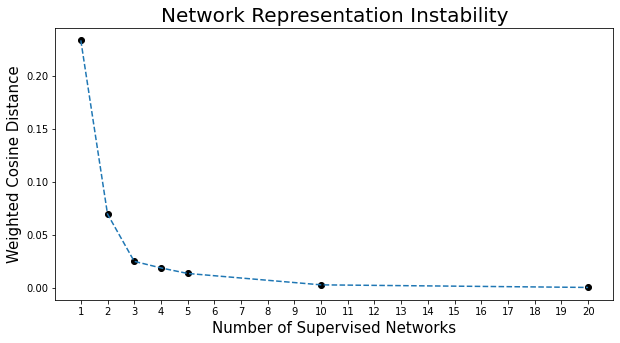

In [25]:
plt.figure(figsize=(10,5))
#plt.errorbar([1,2,3,4,5,10,20],mean_similarity,
#        yerr=sterr_similarity,linestyle="-.",label="mean scaled cosine distance")
plt.plot([1,2,3,4,5,10,20],median_similarity,linestyle="dashed",label="median scaled cosine distance")
plt.scatter([1,2,3,4,5,10,20],median_similarity,color="black")
#plt.legend()
plt.xticks(range(1,21),range(1,21))
plt.xlabel("Number of Supervised Networks",fontsize=15)
plt.ylabel("Weighted Cosine Distance",fontsize=15)
plt.title("Network Representation Instability",fontsize=20)
#plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/n_sup_nets/n_sup_consistency.svg")
plt.show()

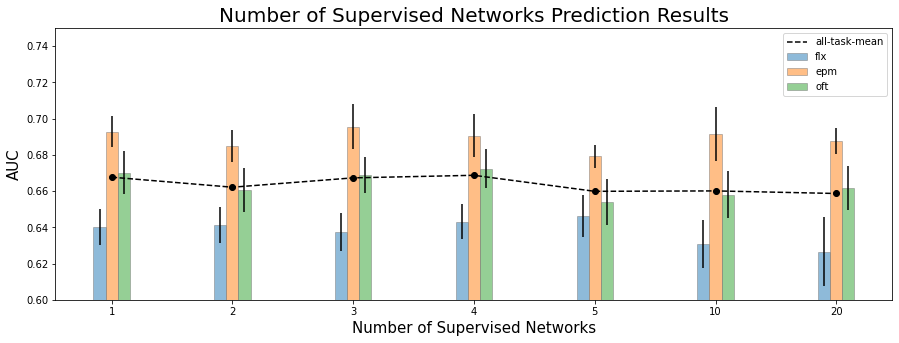

In [24]:
flx_mean_auc_list = np.array(flx_mean_auc_list)
epm_mean_auc_list = np.array(epm_mean_auc_list)
oft_mean_auc_list = np.array(oft_mean_auc_list)

all_means = np.vstack([flx_mean_auc_list,epm_mean_auc_list,oft_mean_auc_list])

mean_auc = np.mean(all_means,axis=0)
sterr_auc = np.std(all_means,axis=0) / np.sqrt(3)

barWidth = 0.1
fig = plt.subplots(figsize=(15,5))

br1 = np.arange(len(oft_mean_auc_list))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, flx_mean_auc_list,yerr=flx_sterr_auc_list,
        width = barWidth, edgecolor ='grey', label ='flx',alpha=0.5)

plt.bar(br2, epm_mean_auc_list,yerr=epm_sterr_auc_list, width = barWidth,
        edgecolor ='grey', label ='epm',alpha=0.5)

plt.bar(br3, oft_mean_auc_list,yerr=oft_sterr_auc_list, width = barWidth,
        edgecolor ='grey', label ='oft',alpha=0.5)

# Make the plot
#plt.plot(br1, flx_mean_auc_list, label ='flx',linestyle="-.",alpha=0.5)

#plt.plot(br2, epm_mean_auc_list, label ='epm',linestyle="-.",alpha=0.5)

#plt.plot(br3, oft_mean_auc_list, label ='oft',linestyle="-.",alpha=0.5)

plt.plot(br2, mean_auc,label="all-task-mean",linestyle="--",color="black")
plt.scatter(br2, mean_auc,color="black")
plt.xlabel('Number of Supervised Networks', fontsize = 15)
plt.ylabel('AUC', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(oft_mean_auc_list))],
        [1,2,3,4,5,10,20])
plt.ylim([.6,.75])
plt.legend(prop={'size':10})
n_nets_list = [1,2,3,4,5,10,20]
plt.title("Number of Supervised Networks Prediction Results", fontsize=20)
#plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/n_sup_nets/n_sup_prediction.svg")
plt.show()

In [8]:
predictive_dictionary = {
    "flx_mean_auc":flx_mean_auc_list,
    "flx_sterr":flx_sterr_auc_list,
    "epm_mean_auc":epm_mean_auc_list,
    "epm_sterr":epm_sterr_auc_list,
    "oft_mean_auc":oft_mean_auc_list,
    "oft_sterr":oft_sterr_auc_list,
    "mean_auc":mean_auc,
    "n_nets":n_nets_list,
}

df_pred = pd.DataFrame.from_dict(predictive_dictionary)
#df_pred.to_csv("n_sup_nets_prediction.csv")

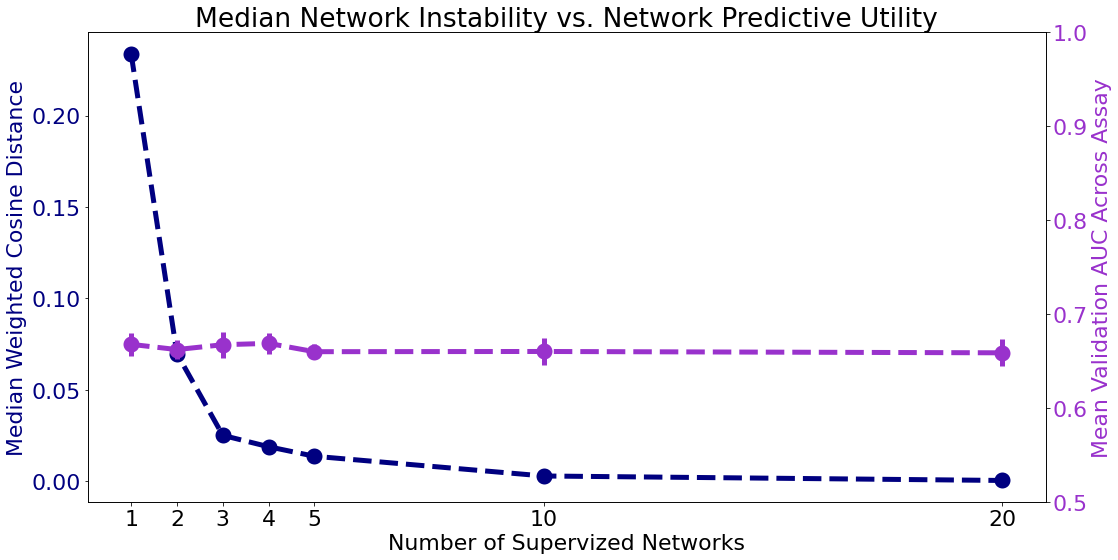

In [68]:
x = [1,2,3,4,5,10,20]
y1 = median_similarity
y1_err = sterr_similarity
y2 = mean_auc
y2_err = sterr_auc
linewidth=5
scatterLw=10
fig, ax1 = plt.subplots()
fig.set_size_inches(16,8)
plt.rcParams.update({'font.size':22})
ax1color="navy"
ax1.set_xlabel("Number of Supervized Networks")
ax1.set_ylabel("Median Weighted Cosine Distance",color=ax1color)
ax1.plot(x,y1,linestyle="dashed",color=ax1color,linewidth=linewidth)
ax1.tick_params(axis="y",labelcolor=ax1color)
#ax1.errorbar(x,y1,yerr=y1_err,color="black",linestyle="dashdot")
plt.scatter(x,y1,color=ax1color,linewidth=scatterLw)
plt.xticks(x,x)
ax2 = ax1.twinx()

plt.rcParams.update({'font.size':22})
ax2color="darkorchid"
ax2.set_ylabel("Mean Validation AUC Across Assay",color=ax2color)
#ax2.plot(x,y2,linestyle="dashed")
ax2.errorbar(x,y2,yerr=y2_err,linestyle="dashed",color=ax2color,linewidth=linewidth)
ax2.scatter(x,y2,color=ax2color,linewidth=scatterLw)
ax2.tick_params(axis='y',labelcolor=ax2color)
ax2.set_ylim([0.5,1.0])
fig.tight_layout()

plt.title("Median Network Instability vs. Network Predictive Utility")
plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/n_sup_stability_vs_auc.svg")
plt.show()